In [1]:
import pandas as pd
import numpy as np
import math
import random
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import datetime

In [2]:
filename = "sap_storing_data_hu_project.csv" 
df_not_cleaned = pd.read_csv(filename, low_memory=False)
#verwijder alle kolommen die niet van gebruik zijn:
df = df_not_cleaned.drop(columns=['stm_sap_mon_meld_ddt', 'stm_mon_begin_ddt', 'stm_mon_toelichting_trdl', 'stm_oh_pg_mld', 'stm_geo_mld_uit_functiepl', 'stm_scenario_mon', 'stm_status_melding_sap', 'stm_mon_nr_status_omschr', 'stm_mon_nr__statuscode', 'stm_mon_nr_status_wijzdd', 'stm_aanntpl_ddt', 'stm_geo_gst_uit_functiepl', 'stm_objectdl_code_gst', 'stm_objectdl_groep_gst', 'stm_progfh_in_ddt', 'stm_progfh_in_invoer_ddt', 'stm_progfh_gw_ddt', 'stm_progfh_gw_lwd_ddt', 'stm_progfh_hz', 'stm_veroorz_groep', 'stm_veroorz_code', 'stm_progfh_gw_duur', 'stm_progfh_gw_lwd_tijd', 'stm_progfh_gw_lwd_datum', 'stm_progfh_gw_datum', 'stm_arbeid', 'stm_functiepl_gst', 'stm_functiepl_mld', 'stm_mon_begintijd', 'stm_mon_begindatum', 'stm_aangelegd_tijd', 'stm_aangelegd_dd', 'stm_dir_betrok_tr', 'stm_evb', 'stm_mon_vhdsincident', 'stm_mon_eind_ddt', 'stm_afspr_aanvangddt', 'stm_effect', 'stm_veroorz_tekst_kort', 'stm_projnr', 'stm_wbi_nummer', 'stm_status_gebr', 'stm_standplaats', 'stm_actie', 'stm_hinderwaarde', 'stm_rec_toegev_ddt', 'stm_afsluit_tijd', 'stm_afsluit_dd', 'stm_afsluit_ddt', 'stm_akkoord_melding_jn', 'stm_fact_jn', 'stm_status_sapnaarmon', 'stm_akkoord_mon_toewijz', 'stm_controle_dd', 'stm_mon_eind_tijd', 'stm_mon_eind_datum', 'stm_reactie_duur', 'stm_afspr_aanvangtijd', 'stm_afspr_aanvangdd', 'stm_historie_toelichting', 'stm_schade_verhaalb_jn', 'stm_x_bron_arch_dt', 'stm_x_bron_bestandsnaam', 'stm_x_bron_publ_dt', 'stm_rapportage_jaar', 'stm_rapportage_maand', 'stm_sorteerveld', 'stm_afspr_func_hersteltijd', 'stm_afspr_func_hersteldd', 'stm_relatiervo', 'stm_relatiervo_volgend', 'stm_relatiervo_vorig', 'stm_schade_statusdatum', 'stm_schade_status_ga', 'stm_schadenr', 'stm_x_start_sessie_dt', 'stm_x_bk', 'stm_x_run_id', 'stm_x_actueel_ind', 'stm_x_vervallen_ind'])
print("Done")

Done


# Data cleaning:


De te bepalen welke variabelen het meest van toepassing zijn om te gebruiken kijken we naar welke
kolommen informatie geven over de tijd van de melding, monteur. Tijd wanneer de melding word opgelost.
Wat voor melding het is en info over de melding/storing, en de locatie. Zo zijn de volgende kolommen
het meest van toepassing:

Over soort melding
- stm_sap_meldtekst (melding omschrijving)
- stm_geo_mld (melding code) - nodig
- stm_oorz_code (oorzaak code) - nodig
- stm_prioriteit (prioriteit)

Over tijd:
- stm_sap_melddatum (datump melding) - nodig
- stm_sap_meldtijd (tijdstip melding) - nodig
- stm_aanngeb_dd (datum aannemer gebeld)
- stm_aanngeb_tijd (tijd aannemer gebeld)
- stm_aanntpl_dd (datum aannemer op plek)
- stm_aanntpl_tijd (tijd aannemer op plek)

- stm_fh_dd (Datum van functie herstel) - nodig
- stm_fh_tijd (Tijdstip van functieherstel) - nodig
- stm_sap_storeinddatum (Datum einde storing) - nodig
- stm_sap_storeindtijd (Tijdstip einde storing) - nodig
- stm_fh_duur (Duur van functiehersteltijd) - nodig

Over equipment:
- stm_equipm_nr_mld (equipment)
- stm_equipm_omschr_mld (equipment omschrijving)

Over locatie
- stm_km_van_mld (locatie van)
- stm_km_tot_mld (locatie tot)
- stm_vl_post (VL post) - nodig
- stm_contractgeb_mld(locatie melding) - nodig
- stm_pplg_van (PPLG van locatie)
- stm_pplg_naar (PPLG tot locatie)
- stm_dstrglp_van (Dienstregelpunt van locatie)
- stm_dstrglp_naar (Dienstregelpunt tot locatie)

Over prognose:
- stm_progfh_in_datum (Datum prognose)
- stm_progfh_in_tijd (Tijdstip FHT prognose)
- stm_progfh_in_invoer_dat (Invoer datum prognose)
- stm_progfh_in_invoer_tijd (Invoer tijdstip FHT prognose)
- stm_progfh_in_duur (Duur FHT)



In [3]:
#deze functie verwijdert alle rijen waar geen value op de gegeven kolommen zitten
def drop_rows_with_null(lst, df):
    dfisnull = df.isnull()[lst]
    matches = dfisnull[(dfisnull).any(axis=1)]
    return df.drop(matches.index)

In [4]:
#Deze functie berkent de uitschiet grenzen
def uitschieters_bereken(kolom):
    q1 = kolom.quantile(0.25)
    q3 = kolom.quantile(0.75)
    iqr = q3 - q1
    maxuitschieter = q3 + (iqr*1.5)
    minuitschieter = q1 - (iqr*1.5)
    return maxuitschieter, minuitschieter

#Deze functie geeft de indexes van uitschieters in een kolom
def return_uitschieters_indexes(kolom):
    maxuitschieter = uitschieters_bereken(kolom)[0]
    minuitschieter = uitschieters_bereken(kolom)[1]
    uitschieters = [kolom[kolom > maxuitschieter].index, kolom[kolom < minuitschieter].index]
    return uitschieters
    
#Deze functie geeft een kolom zonder uitschieters
def return_kolom_zonder_uitschieters(kolom):
    maxuitschieter = uitschieters_bereken(kolom)[0]
    minuitschieter = uitschieters_bereken(kolom)[1]
    kolom = kolom[kolom < maxuitschieter][kolom > minuitschieter]
    return kolom


In [5]:
#Deze functie berkent de extreme uitschiet grenzen
def ex_uitschieters_bereken(kolom):
    q1 = kolom.quantile(0.25)
    q3 = kolom.quantile(0.75)
    iqr = q3 - q1
    maxuitschieter = q3 + (iqr*3)
    minuitschieter = q1 - (iqr*3)
    return maxuitschieter, minuitschieter

#Deze functie geeft de indexes van extreme uitschieters in een kolom
def return_ex_uitschieters_indexes(kolom):
    maxuitschieter = uitschieters_ex_bereken(kolom)[0]
    minuitschieter = uitschieters_ex_bereken(kolom)[1]
    uitschieters = [kolom[kolom > maxuitschieter].index, kolom[kolom < minuitschieter].index]
    return uitschieters
    
#Deze functie geeft een kolom zonder extreme uitschieters
def return_kolom_zonder_ex_uitschieters(kolom):
    maxuitschieter = uitschieters_ex_bereken(kolom)[0]
    minuitschieter = uitschieters_ex_bereken(kolom)[1]
    kolom = kolom[kolom < maxuitschieter][kolom > minuitschieter]
    return kolom

In [6]:
# Verwijder de rijen die geen value bevatten in de benodigde kolommen
df_filtered = drop_rows_with_null(['stm_geo_mld', 'stm_sap_melddatum', 'stm_oorz_code', 'stm_sap_meldtijd',
                          'stm_fh_dd', 'stm_fh_tijd', 'stm_sap_storeinddatum', 'stm_sap_storeindtijd',
                          'stm_fh_duur', 'stm_vl_post', 'stm_contractgeb_mld'], df)
print(len(df))
print(len(df_filtered))
df_filtered

898526
132923


,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_meldtekst_lang,stm_sap_meldtekst,stm_geo_mld,stm_equipm_nr_mld,stm_equipm_soort_mld,...,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_oorz_tekst_kort,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar
85,87,50053389,37.0,EHV,10/01/2006 16:11:00,Logboeknr RBV : 37 Tijd: 1611 VL-Post: ...,Logboeknr RBV : 37 Tijd: 1611 VL-P,618.0,10646141.0,SYSTBOVENL,...,10/01/2006,16:31:00,20.0,11/01/2006,10:33:00,Geen SMC-melding. Afwijzing. Bij het SMC,NaN,NaN,EHV,NaN
123,125,50053438,62.0,AH,15/01/2006 23:08:00,Logboeknr RBV : 62 Tijd: 2308 VL-Post: ...,Logboeknr RBV : 62 Tijd: 2308 VL-P,514.0,10201441.0,WISSEL,...,15/01/2006,23:20:00,12.0,15/01/2006,23:20:00,NaN,NaN,NaN,Nm,NaN
205,208,50053591,39.0,EHV,20/01/2006 14:32:00,Logboeknr RBV : 39 Tijd: 1432 VL-Post: ...,Logboeknr RBV : 39 Tijd: 1432 VL-P,515.0,10527838.0,WISSEL,...,20/01/2006,14:47:00,15.0,23/01/2006,11:39:00,Geen SMC-melding.,NaN,NaN,Vga,NaN
226,229,50053628,250.0,ZL,24/01/2006 20:20:00,Logboeknr RBV : 250 Tijd: 2020 VL-Post: ...,Logboeknr RBV : 250 Tijd: 2020 VL-P,25.0,10211614.0,OVERWEG,...,24/01/2006,20:30:00,10.0,24/01/2006,20:30:00,NaN,NaN,NaN,AMRI,NaN
240,243,50053652,42.0,RSD,25/01/2006 09:30:00,Logboeknr RBV : 42 Tijd: 0930 VL-Post: ...,Logboeknr RBV : 42 Tijd: 0930 VL-P,127.0,10621371.0,DETECTREIN,...,25/01/2006,09:44:00,14.0,30/01/2006,11:21:00,Geen SMC-melding.Geen onderzoek geweest.,NaN,NaN,Arn,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898413,908517,99003207,3669429.0,MT,21/05/2016 13:17:56,[2+] Mtr-Edng : Sp-Sb/TB t.o.b.s. alle ovw'en ...,[2+] Mtr-Edng : Sp-Sb/TB t.o.b.s. alle o,71.0,10621358.0,DETECTREIN,...,21/05/2016,14:35:00,175.0,21/05/2016,14:50:00,Gestoord object: SECTIE 913AT. Gestoord,MTR,NaN,MTR,EDN
898472,908576,99003486,1995699.0,RTD,10/05/2013 17:54:00,"Brd : deuren buis 2, 3, 4 en open tijdens tre...","Brd : deuren buis 2, 3, 4 en open tijden",116.0,10590754.0,TUNCONSTR,...,10/05/2013,19:38:00,104.0,10/05/2013,20:40:00,NaN,RTST,NaN,RTST,RLB
898473,908577,99003486,1995699.0,RTD,10/05/2013 17:54:00,"Brd : deuren buis 2, 3, 4 en open tijdens tre...","Brd : deuren buis 2, 3, 4 en open tijden",116.0,10590754.0,TUNCONSTR,...,10/05/2013,19:38:00,104.0,10/05/2013,20:40:00,NaN,RTST,NaN,RTST,RLB
898474,908578,99003486,1995699.0,RTD,10/05/2013 17:54:00,"Brd TTI: deuren buis 2, 3, 4 en open tijdens ...","Brd TTI: deuren buis 2, 3, 4 en open tij",116.0,10590754.0,TUNCONSTR,...,10/05/2013,19:38:00,104.0,10/05/2013,20:40:00,NaN,RTST,NaN,RTST,RLB


# Data preparation:

In [7]:
df_filtered['stm_sap_meld_ddt'] = df_filtered['stm_sap_meld_ddt'].apply(pd.to_datetime) # maakt het type: datetime

In [8]:
df_year = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.year)
df_filtered.insert(5, 'Jaar', df_year) # zet het jaar los in de tabel

In [9]:
df_day = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.dayofyear)
df_filtered.insert(6, 'Dag_van_jaar', df_day) # zet de dag count van het jaar los in de tabel (1-365)

In [10]:
df_hour = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.hour)
df_filtered.insert(7, 'Uur_van_dag', df_hour) # zet het uur van de dag los in de tabel (0-23)

In [11]:
df_min = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.minute)
df_filtered.insert(8, 'Minuut_van_uur', df_min) # zet de minuten van het uur los in de tabel (0-59)

In [12]:
df_hour_min = (df_filtered['Uur_van_dag'] * 60) + df_filtered['Minuut_van_uur']
df_filtered.insert(9, 'Minuut_van_dag', df_hour_min) # zet de minuut van de dag in een tabel (0-1440)

In [13]:
# hoger dan 5 minuten,als het onder de 5 minuten zit is er een goede kans dat het een fout was.
df_filtered = (df_filtered.loc[(df_filtered['stm_fh_duur'] > 5) & (df_filtered['stm_fh_duur'] < 360)])
df_filtered = (df_filtered[(df_filtered['stm_km_van_mld'] < 500)]) # minder dan 500 km omdat het anders onrealistisch grote 
# afstanden worden voor Nederland.

In [14]:
# minuut van de dag dat de aannemer ter plekken is gekomen lijst gemaakt en in dataset gezet.
df_filtered['stm_aanntpl_tijd'] = df_filtered['stm_aanntpl_tijd'].apply(pd.to_datetime)
df_hour = pd.DataFrame(df_filtered['stm_aanntpl_tijd'].dt.hour)
df_filtered.insert(0, 'Uur_herstel', df_hour)
df_min = pd.DataFrame(df_filtered['stm_aanntpl_tijd'].dt.minute)
df_filtered.insert(1, 'Min_van_uur_herstel', df_min)
df_min_of_day_herstel = (df_filtered['Uur_herstel'] * 60) + df_filtered['Min_van_uur_herstel']
df_filtered.insert(2, 'Minuut_van_dag_herstel', df_min_of_day_herstel)
# Eigenlijk precies hetzelfde als hier boven maar dan in 1 cel

In [15]:
# minuut van de dag dat de aannemer klaar is lijst gemaakt en in dataset gezet.
df_filtered['stm_fh_ddt'] = df_filtered['stm_fh_ddt'].apply(pd.to_datetime)
df_hour2 = pd.DataFrame(df_filtered['stm_fh_ddt'].dt.hour)
df_filtered.insert(3, 'Uur_hersteld', df_hour2)
df_min2 = pd.DataFrame(df_filtered['stm_fh_ddt'].dt.minute)
df_filtered.insert(4, 'Min_van_uur_hersteld', df_min2)
df_min_of_day_herstel2 = (df_filtered['Uur_hersteld'] * 60) + df_filtered['Min_van_uur_hersteld']
df_filtered.insert(5, 'Minuut_van_dag_hersteld', df_min_of_day_herstel2)
# Eigenlijk precies hetzelfde als hier boven maar dan in 1 cel

In [16]:
Echte_herstel_tijd = df_filtered['Minuut_van_dag_hersteld'] - df_filtered['Minuut_van_dag_herstel']
df_filtered.insert(6, 'Echte_hersteltijd', Echte_herstel_tijd)
# berekent het verschil tussen de minuten van de dag (dus het berekent eigenlijk de reparatie tijd, 
# van aankomst aannemer tot gefixt)

In [45]:
# hoger dan 5 minuten,als het onder de 5 minuten zit is er een goede kans dat het een fout was.
df_filtered = (df_filtered.loc[(df_filtered['Echte_hersteltijd'] > 5) & (df_filtered['Echte_hersteltijd'] < 360)])

# Baseline
Target variabele is 'stm_fh_duur'. Dit is de functie hersteltijd dit houd in dat vanaf de melding tot dat het probleem opgelost is getimed wordt. 

baseline:  

In [18]:
# De target variabele filteren tussen de 0 min en 360 min. Prodcut ower gaf dit als grens aan. 
#data_fht = df_filtered['stm_fh_duur'].loc[(df_filtered['stm_fh_duur'] > 0) & (df_filtered['stm_fh_duur'] < 360)]
data_fht = df_filtered['Echte_hersteltijd'].loc[(df_filtered['Echte_hersteltijd'] > 0) & (df_filtered['Echte_hersteltijd'] < 360)]
data_fht

351        27
353       288
609       260
664         6
669       110
         ... 
898208     15
898410     40
898411     40
898412     40
898413     40
Name: Echte_hersteltijd, Length: 21429, dtype: int64

In [19]:
data_fht.describe()

count    21429.000000
mean        63.454338
std         57.675521
min          6.000000
25%         24.000000
50%         45.000000
75%         82.000000
max        350.000000
Name: Echte_hersteltijd, dtype: float64

In [20]:
data_fht.mean()

63.45433757991507

In [21]:
data_fht.median()

45.0

<AxesSubplot:>

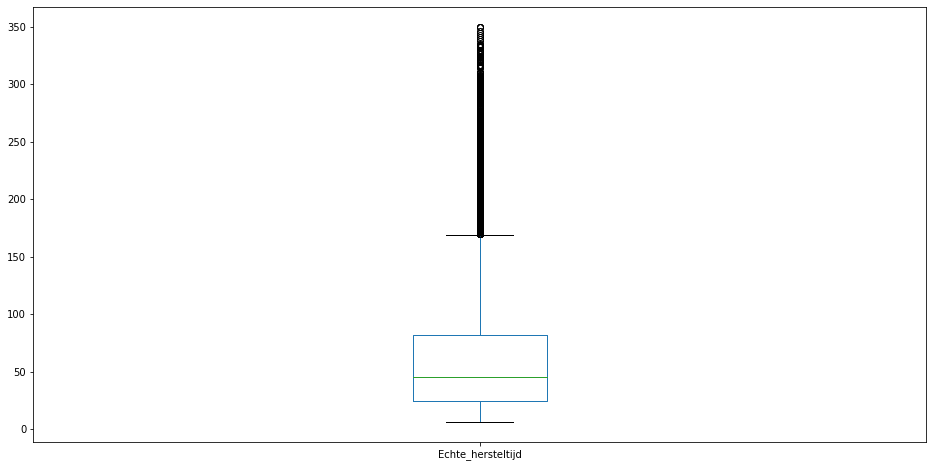

In [22]:
data_fht.plot.box(figsize=(16,8))

In [23]:
len(data_fht[data_fht < data_fht.mean()])

13974

In [24]:
len(data_fht[data_fht < data_fht.mean()])/len(data_fht)*100

65.21069578608429

In [25]:
len(data_fht[data_fht < data_fht.median()])/len(data_fht)*100

48.52769611274441

65% van alle herstel tijden zit onder het gemiddelde 102 min

48% van alle herstel tijden zit onder de mediaan 82 min



In [26]:
data_fht = data_fht.to_frame()
#data_fht['mediaan'] = data_fht['stm_fh_duur'].median()
data_fht['mediaan'] = data_fht['Echte_hersteltijd'].median()
#data_fht['mean'] = data_fht['stm_fh_duur'].mean()
data_fht['mean'] = data_fht['Echte_hersteltijd'].mean()
data_fht.head()

,Echte_hersteltijd,mediaan,mean
351,27,45.0,63.454338
353,288,45.0,63.454338
609,260,45.0,63.454338
664,6,45.0,63.454338
669,110,45.0,63.454338


In [27]:
# de score bepalen aan de hand van de RSME
#np.sqrt(mean_squared_error(data_fht.loc[:,'stm_fh_duur'],data_fht.loc[:,'mean']))
np.sqrt(mean_squared_error(data_fht.loc[:,'Echte_hersteltijd'],data_fht.loc[:,'mean']))

57.674175679913716

In [28]:
#de score bepalen aan de hand van de RSME
#np.sqrt(mean_squared_error(data_fht.loc[:,'stm_fh_duur'],data_fht.loc[:,'mediaan']))
np.sqrt(mean_squared_error(data_fht.loc[:,'Echte_hersteltijd'],data_fht.loc[:,'mediaan']))

60.554711756154994

# KNeighborsregression

In [29]:
X = df_filtered[['stm_km_van_mld', 'stm_prioriteit', 'Dag_van_jaar', 'Jaar', 'Minuut_van_dag']]
#y = df_filtered[['stm_fh_duur']] # oude niet 'echte' hersteltijd.
y = df_filtered[['Echte_hersteltijd']]

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

clf

KNeighborsClassifier()

In [32]:
clf.fit(X_train, y_train)

<ipython-input-32-4f66baab8f93>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  clf.fit(X_train, y_train)


KNeighborsClassifier()

In [33]:
y_pred_train = clf.predict(X_train)

y_pred_test = clf.predict(X_test)

In [34]:
from sklearn.metrics import accuracy_score

print('Accuracy traindata')
print(accuracy_score(y_train, y_pred_train))

print('')
print('Accuracy testdata')
print(accuracy_score(y_test, y_pred_test))

Accuracy traindata
0.465570880431401

Accuracy testdata
0.24498366775548297


In [35]:
y_pred_test_KN = clf.predict(X_test)

error_metric_KN = np.sqrt(mean_squared_error(y_pred=y_pred_test, y_true=y_test))
print(error_metric_KN)

66.7301836166086


In [36]:
df_filtered['stm_km_van_mld'].describe()

count    21429.000000
mean         7.032153
std         46.864075
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        498.000000
Name: stm_km_van_mld, dtype: float64

# linear regression 

In [37]:
X = df_filtered[['stm_km_van_mld', 'stm_prioriteit', 'Dag_van_jaar', 'Jaar', 'Minuut_van_dag']]
#y = df_filtered[['stm_fh_duur']]
y= df_filtered[['Echte_hersteltijd']]

In [38]:
# de data splitsen in training en testing data
from sklearn.model_selection import train_test_split
# test_size
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=None) 

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
linear_reg_model = LinearRegression()

In [41]:
linear_reg_model.fit(X_train, y_train)

LinearRegression()

In [42]:
from sklearn.metrics import mean_squared_error

y_pred_test = linear_reg_model.predict(X_test)

error_metric = np.sqrt(mean_squared_error(y_pred=y_pred_test, y_true=y_test))
print(error_metric)

59.114044473110205


Text(0.5, 1.0, 'voorspelling tegen over daadwerkelijke data')

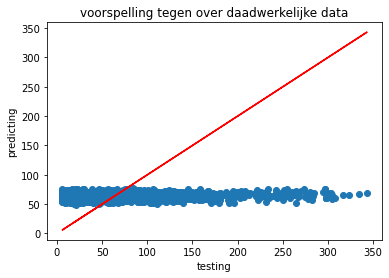

In [43]:
# model plotten en lineare regressie er in verwerken
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_test)
ax.plot(y_test, y_test, color='red')
ax.set_xlabel('testing')
ax.set_ylabel('predicting')
ax.set_title('voorspelling tegen over daadwerkelijke data')

In [44]:
from collections import OrderedDict
new_data = OrderedDict([
    ('stm_km_van_mld',50),
    ('stm_prioriteit',5),
    ('Dag_van_jaar',214),
    ('Jaar',2020),
    ('Minuut_van_dag', 800)
])

new_data = pd.Series(new_data).values.reshape(1,-1)

linear_reg_model.predict(new_data)

array([[65.91454001]])